In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

color_pallette = 'muted'
sns.set_theme(style='whitegrid', font_scale=1.5, palette=color_pallette, 
              rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 16

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time',
                   'model_size [MB]', 'gpu_memory_used', 'memory [MB]', 'parameters']

def manage_model_name(name: str) -> str:
    spl = name.split('/')
    if len(spl) == 2:
        return spl[1]
    else:
        return name

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_name'] = df['model_name'].apply(lambda x: manage_model_name(x))
    
    df['model_size [MB]'] = df['model_size']/MB
    df['memory [MB]'] = df['memory']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):
        
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.02)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [MB]', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Memory [MB]', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Parameters', title = 'Parameters', ax=ax6)
    
    fig.suptitle(suptitle)
#     fig.tight_layout()   
#     file_name = suptitle.replace(':', '').replace(' ','-') + '.pdf'
#     fig.savefig(file_name, bbox_inches='tight')


def visualize_models_comparision(df: pd.DataFrame, reference_model: str, models: List[str], suptitle: str = ''):
    cols = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision',
     'training_time_in_minutes', 'eval_time',
        'model_size [MB]', 'memory [MB]', 'parameters']
    
    df = df[df['model_name'].isin(models + [reference_model])].copy()[cols]
    values_for_ref = {c: df[df['model_name'] == reference_model][c].values[0] for c in df.columns}
    
    measures = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision']
    for measure in measures:    
        df[measure + '_diff'] = df[measure].apply(lambda x: x - values_for_ref[measure])
        
    for time_measure in ['training_time_in_minutes', 'eval_time']:    
        df[time_measure + '_speedup'] = df[time_measure].apply(lambda x: values_for_ref[time_measure] / x)
        
    for size_measure in ['model_size [MB]', 'memory [MB]', 'parameters']:    
        df[size_measure + '_compression'] = df[size_measure].apply(lambda x: values_for_ref[size_measure] / x)

#     display(df)
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    palette = np.array(sns.color_palette(color_pallette))[1:]
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['model_name']   
    measures_to_plot = [m + '_diff' for m in measures]
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
        
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize() for col in measures_to_plot]
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0", data=df_measures, ax=ax1,
                palette=palette)
    
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title ='Training time', ax=ax2, palette=palette)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title = 'Eval time', ax=ax3, palette=palette)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Size on drive', ax=ax4, palette=palette)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Memory usage', ax=ax5, palette=palette)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Parameters', ax=ax6, palette=palette)
    
    fig.suptitle(suptitle)

     
def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None, palette=None):
    if palette is not None:
        ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax, palette=palette)
    else:
        ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)                     # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar


# Multiemo EN - All sentences

BERT_Base, DistilBERT, TinyBERT

In [3]:
file_name = 'results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df_base = load_results_df(file_path)

df_base = df_base[df_base['model_name'].isin(['bert-base-uncased', 'distilbert-base-uncased', 'TinyBERT_General_4L_312D', 
                              'TinyBERT_General_6L_768D'])]

df_base = df_base.drop(columns=['epochs', 'batch_size', 'learning_rate', 'weight_decay', 'warmup_steps'])

Bert-of-Theseus

In [4]:
file_name = 'results-bert-of-theseus-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)
df_theseus = load_results_df(file_path)

columns_to_drop = set(df_theseus.columns) - set(df_base.columns)
df_theseus = df_theseus.drop(columns=columns_to_drop)

DynaBERT

In [5]:
file_name = 'results-dynabert-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df_dynabert = load_results_df(file_path)

columns_to_drop = set(df_dynabert.columns) - set(df_base.columns)
df_dynabert = df_dynabert.drop(columns=columns_to_drop)

TernaryBERT

In [6]:
file_name = 'results-ternarybert-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df_ternary = load_results_df(file_path)

columns_to_drop = set(df_ternary.columns) - set(df_base.columns)
df_ternary = df_ternary.drop(columns=columns_to_drop)

RoSITa

In [7]:
file_name = 'results-rosita-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df_rosita = load_results_df(file_path)

columns_to_drop = set(df_rosita.columns) - set(df_base.columns)
df_rosita = df_rosita.drop(columns=columns_to_drop)

In [8]:
df = pd.concat([df_base, df_theseus, df_dynabert, df_ternary, df_rosita], ignore_index=True)

## Wykresy

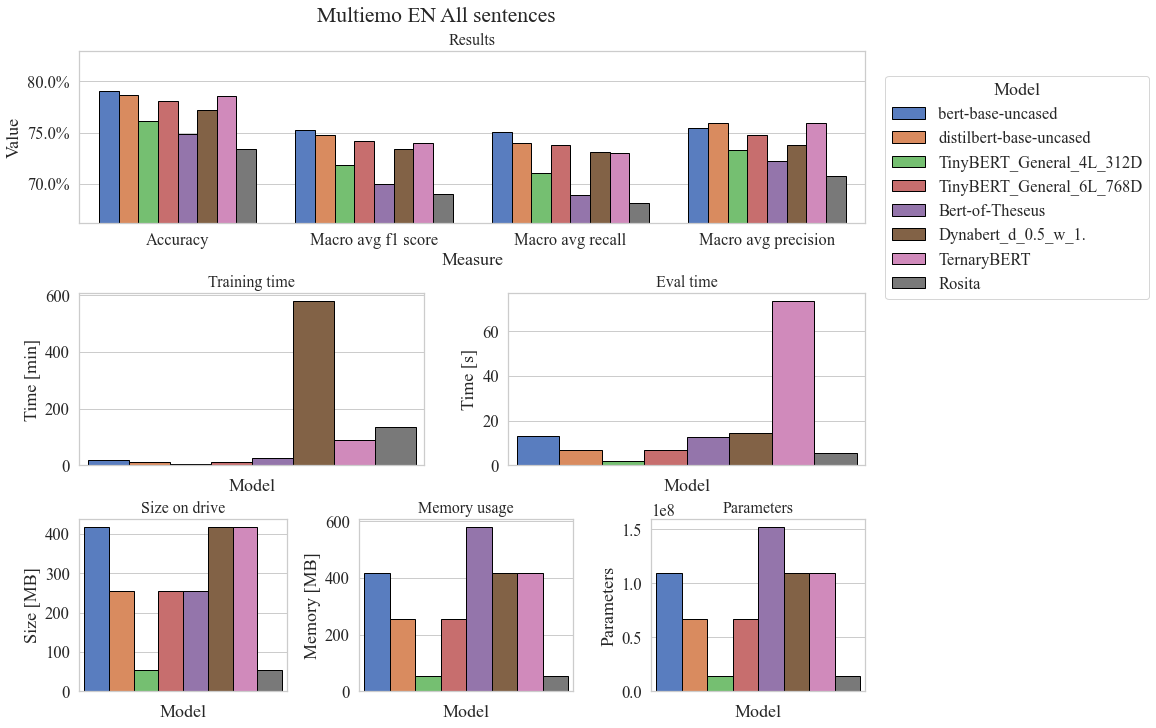

In [10]:
models = ['bert-base-uncased', 'distilbert-base-uncased', 'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'Bert-of-Theseus', 'Dynabert_d_0.5_w_1.', 'TernaryBERT', 'Rosita']
visualize_models(df, models, suptitle='Multiemo EN All sentences')

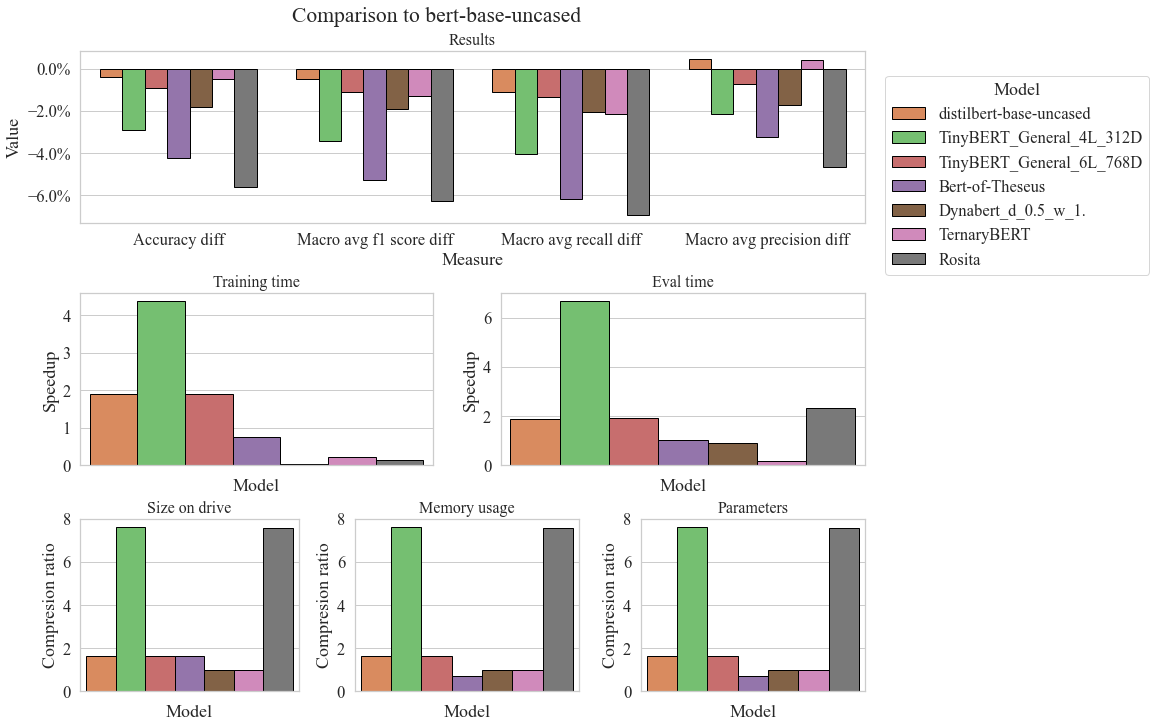

In [11]:
ref_model = 'bert-base-uncased'
models = ['distilbert-base-uncased', 'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'Bert-of-Theseus', 'Dynabert_d_0.5_w_1.', 'TernaryBERT', 'Rosita'
         ]
visualize_models_comparision(df, ref_model, models, suptitle='Comparison to {}'.format(ref_model))

## Bez DynaBERT

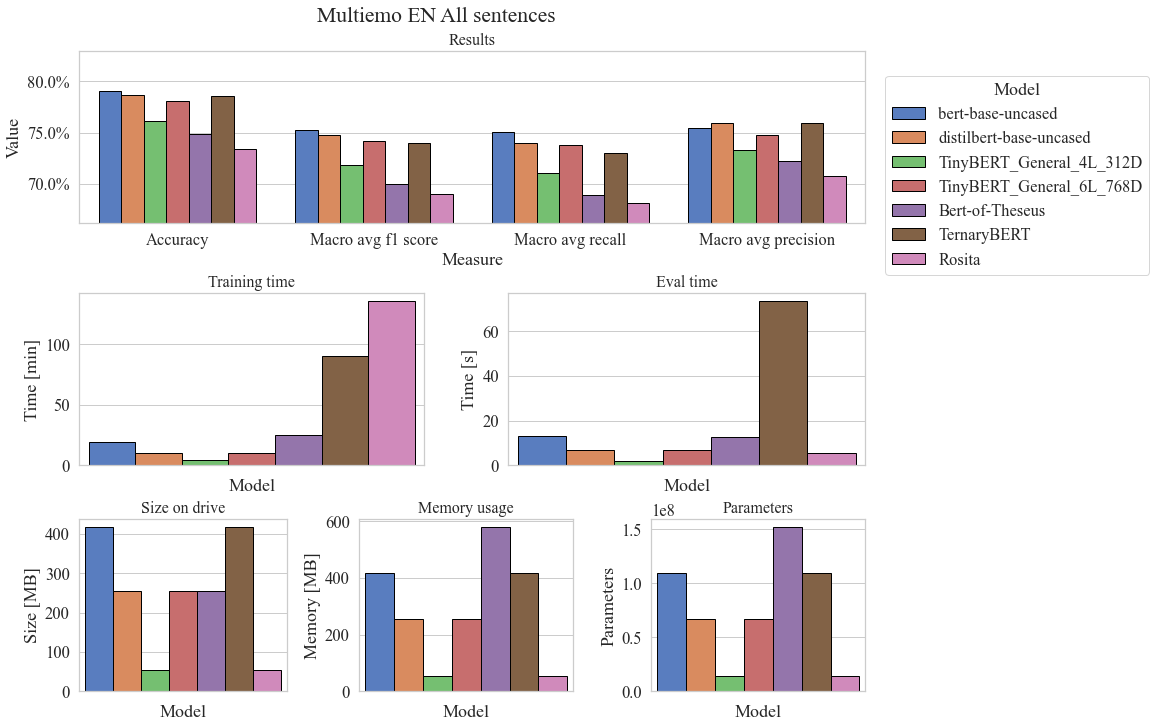

In [12]:
models = ['bert-base-uncased', 'distilbert-base-uncased', 'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'Bert-of-Theseus', 'TernaryBERT', 'Rosita']
visualize_models(df, models, suptitle='Multiemo EN All sentences')

## Bez TerneryBERT

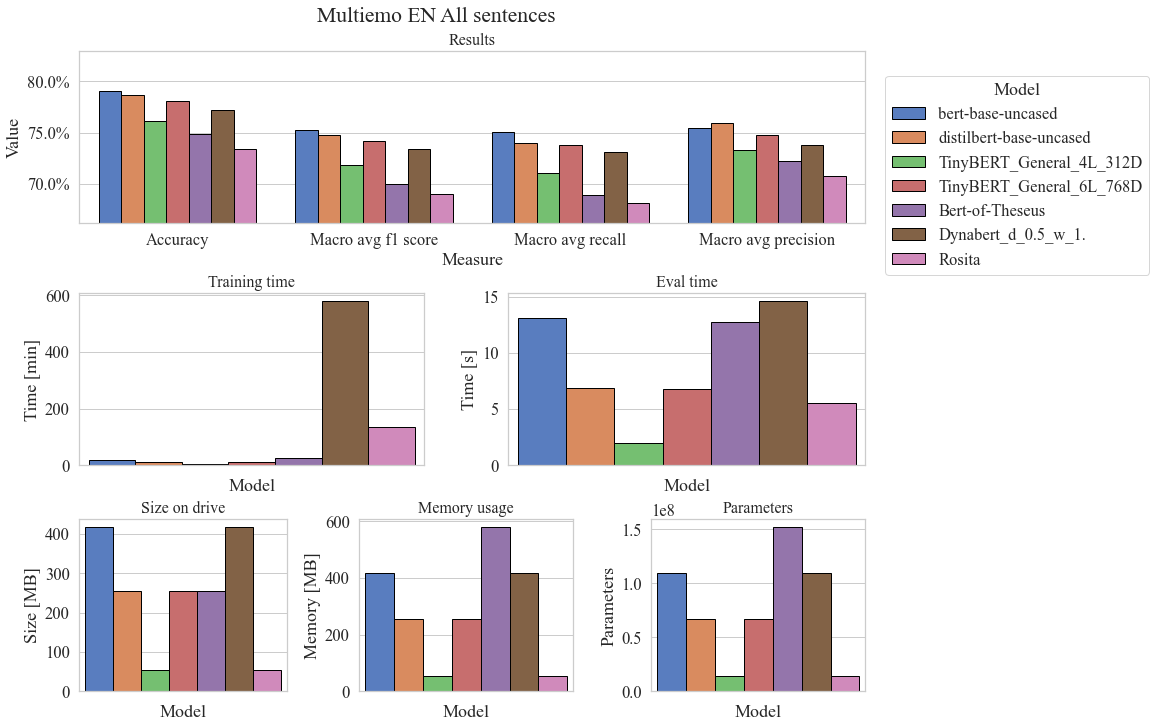

In [13]:
models = ['bert-base-uncased', 'distilbert-base-uncased', 'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
          'Bert-of-Theseus', 'Dynabert_d_0.5_w_1.', 'Rosita']
visualize_models(df, models, suptitle='Multiemo EN All sentences')